# 1D steady-state heat equation with a variable coefficient

## Problem description:

$$\nabla \cdot \left ( k \nabla u \right ) = 0 \quad {\rm in} \ \Omega, \\
u = -10 \quad {\rm on} \ \Gamma_{D1}, \\
u = 10 \quad {\rm on} \ \Gamma_{D2}, \\
$$
$$\Omega = [0,1]$$
$$\Gamma_{D1} = \{0 \subset \partial \Omega\}$$
$$\Gamma_{D2} = \{1 \subset \partial \Omega\}$$

The problem domain is a 1D unit interval and the temperature profile $u$ is sought after.
The left side of the domain consists of ice, the right side of the domain consists of water. 
It is assumemd that the net heat flux into the domain is 0.0 W/m2 and $\frac{\partial u}{\partial t} = 0$ (steady state).
The parameter $p$ defines where the interface changes from ice to water.
The thermal conductivity $k$ varies over the domain.

Thermal conductivity of ice at -10°C: $k_1 = 2.3$ W/mK

Thermal conductivity of water at +10°C: $k_2 = 0.57864$ W/mK

## Numerical computations:

In [1]:
from dolfin import (UnitIntervalMesh, FunctionSpace, TrialFunction, DOLFIN_EPS,
                    TestFunction, Constant, dx, DirichletBC, solve, Function,
                    inner, grad, set_log_active, errornorm)
import matplotlib.pyplot as plt
import numpy as np

First we set up some variables of the problem and we want to define the profile of the thermal conductivity over the domain. There is a parameter p that defines where the interface changes from ice to water.

In [2]:
m = 10001  # rows in snapshot matrix
n = 101  # columns in snapshot matrix
u_left = Constant(-10.0)  # temperature left boundary
u_right = Constant(10.0)  # temperature right boundary
k1 = 2.3  # thermal conductivity of ice at -10°C in W/mK
k2 = .57864  # thermal conductivity of water at +10°C in W/mK


def step(x, p):
    k_np = np.zeros_like(x)
    k_np[x <= p] = k1
    k_np[x > p] = k2
    return k_np


def sigmoid(x, p):
    y = 1.0 / (1+np.e**((x-p)*50))
    return y*(k1-k2)+k2

Now the problem can be decribed with FEniCS

In [3]:
# Define Dirichlet boundaries
def left(x):
    return x[0] < DOLFIN_EPS


def right(x):
    return x[0] > (1.0 - DOLFIN_EPS)

# Create mesh and define function space
mesh = UnitIntervalMesh(m-1)
x = mesh.coordinates()[:, 0]
x_elem = (x[1:]+x[:-1])/2
V = FunctionSpace(mesh, "CG", 1)
Q = FunctionSpace(mesh, "DG", 0)
# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
k = Function(Q)  # V, Q
a = inner(k*grad(u), grad(v))*dx
f = Constant(0.0)
L = f*v*dx  # + g*v*ds
# Define boundary condition
bcs = [DirichletBC(V, u_left, left),  DirichletBC(V, u_right, right)]
u = Function(V)

What is left to do is only to iterate over the profiles and some values for the parameter. The results are collected in a snpshot matrix X which is then decomposed using the SVD.

In [4]:
S_all = []
us = [[], []]
X_all = [np.zeros((m, n)), np.zeros((m, n))]
set_log_active(False)
for j, thermal_conductivity in enumerate([step, sigmoid]):
    X = X_all[j]
    for i, p in enumerate(np.linspace(0, 1, n, endpoint=False)):
        k.vector().vec().array = thermal_conductivity(x_elem, p)
        # Compute solution
        solve(a == L, u, bcs)
        X[:, i] = u.vector().vec().array
        us[j][i:i] = [u.copy(deepcopy=True)]

    U, S, VT = np.linalg.svd(X, full_matrices=False)
    X_approx = np.matmul(U * S, VT)
    print("machine precision of SVD?:", np.allclose(X_approx, X))
    S_all[0:0] = [S]

machine precision of SVD?: True
machine precision of SVD?: True


0.19975801394236262


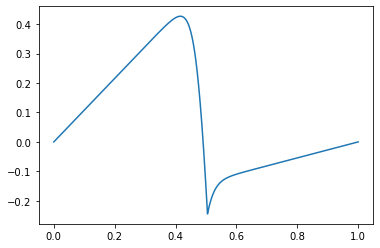

In [5]:
print(errornorm(us[1][50], us[0][50]))

fig, ax = plt.subplots()
#plt.plot(x, X_all[1][:, 0])
#plt.plot(x, X_all[0][:, 0])
plt.plot(x, X_all[0][:, 50]-X_all[1][:, 50])

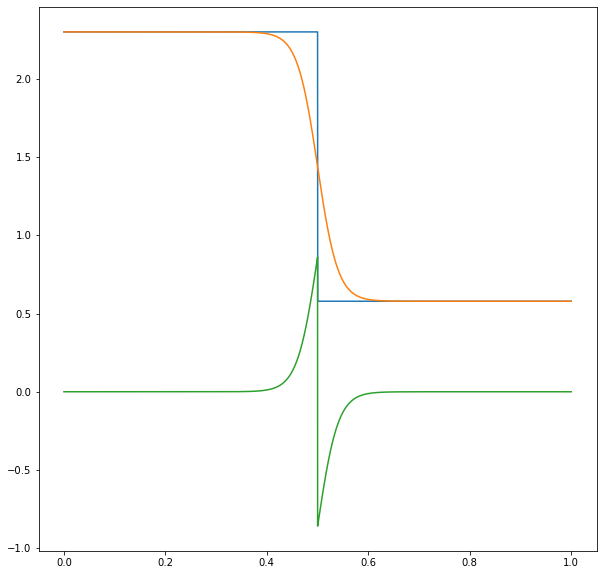

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(x, step(x, .5))
plt.plot(x, sigmoid(x, .5))
plt.plot(x, step(x, .5)-sigmoid(x, .5))

## Visualizations:

plot thermal conductivity profile

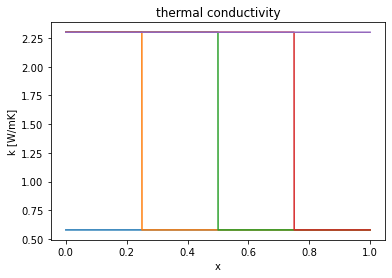

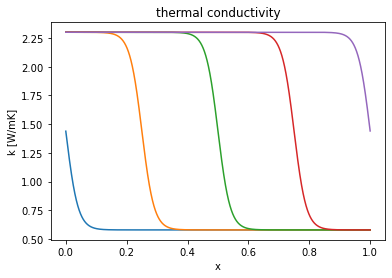

In [7]:
for j, thermal_conductivity in enumerate([step, sigmoid]):
    X = X_all[j]
    fig, ax = plt.subplots()
    ax.plot(x_elem, thermal_conductivity(x_elem, 0))
    ax.plot(x_elem, thermal_conductivity(x_elem, .25))
    ax.plot(x_elem, thermal_conductivity(x_elem, .5))
    ax.plot(x_elem, thermal_conductivity(x_elem, .75))
    ax.plot(x_elem, thermal_conductivity(x_elem, 1.0))
    ax.set_xlabel("x")
    ax.set_ylabel("k [W/mK]")
    plt.title("thermal conductivity")
    plt.show()

plot 10 snapshots

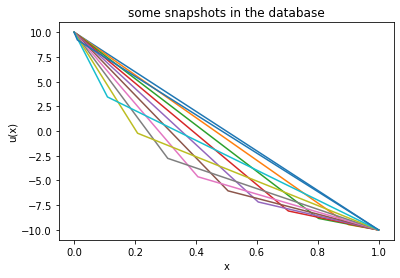

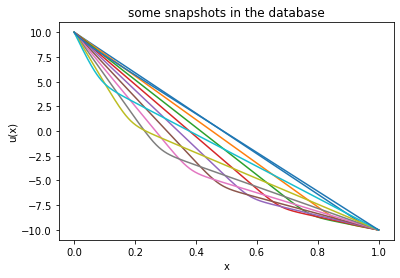

In [8]:
for j, thermal_conductivity in enumerate([step, sigmoid]):
    X = X_all[j]
    fig, ax = plt.subplots()
    for i in np.linspace(0, n-1, 11, dtype=int):
        if i < X.shape[1]:
            ax.plot(x, X[:, i])
    ax.set_xlabel("x")
    ax.set_ylabel("u(x)")
    plt.title("some snapshots in the database")
    plt.show()

plot all snapshots

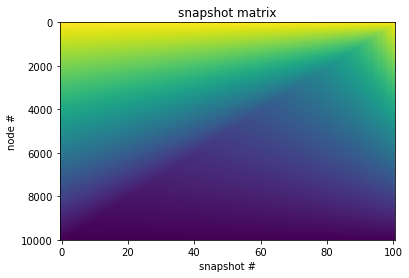

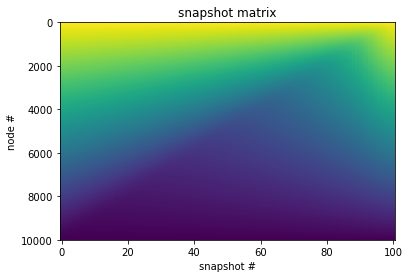

In [9]:
for j, thermal_conductivity in enumerate([step, sigmoid]):
    X = X_all[j]
    fig, ax = plt.subplots()
    ax.imshow(X, interpolation="nearest")
    ax.set_aspect("auto")
    ax.set_xlabel("snapshot #")
    ax.set_ylabel("node #")
    plt.title("snapshot matrix")
    plt.show()

plot singular values

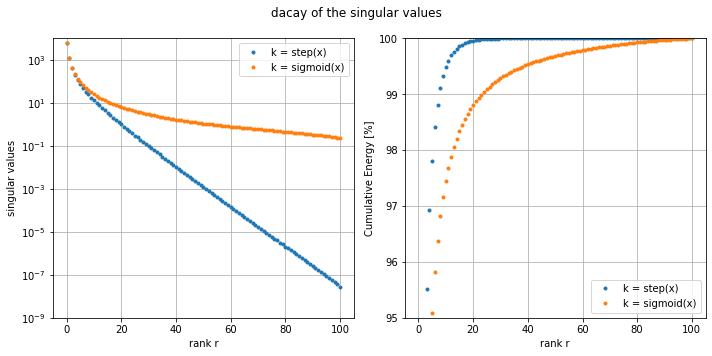

In [10]:
lbl = ["k = step(x)", "k = sigmoid(x)"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
for i, S in enumerate(S_all):
    ax1.plot(np.arange(0, len(S)), S, ".", label=lbl[i])
    ax2.plot(np.arange(0, len(S)), np.cumsum(S)/S.sum()*100, ".", label=lbl[i])
ax1.set_xlabel("rank r")
ax1.set_ylabel("singular values")
ax2.set_xlabel("rank r")
ax1.set_yscale('log')
ax1.set_ylim([1e-9, 1e4])
ax2.set_ylim([95, 100])
ax2.set_ylabel("Cumulative Energy [%]")
ax1.legend()
ax2.legend()
ax1.grid(which="both")
plt.suptitle("dacay of the singular values")
# ax1.set_xlim([0, 1000])
# ax2.set_xlim([0, 200])
plt.grid()
plt.tight_layout()
plt.show()